In [1]:
import torch
import torch.nn as nn
import timm
from pathlib import Path
from dataset_loader import VideoFolderDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
from tqdm.auto import tqdm

# Define model architecture (from CNN+LSTM_training.ipynb)
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self, feature_dim=256, freeze=True):
        super().__init__()
        # Load pretrained EfficientNetB0
        self.effnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        
        # Freeze backbone
        if freeze:
            for param in self.effnet.parameters():
                param.requires_grad = False
        
        # Bottleneck layer: 1280 -> 256
        self.bottleneck = nn.Sequential(
            nn.Linear(1280, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.2)  # Reduced dropout for small dataset
        )
    
    def forward(self, x):
        # x: (B*T, C, H, W)
        features = self.effnet(x)  # (B*T, 1280)
        features = self.bottleneck(features)  # (B*T, 256)
        return features

class LSTMEncoder(nn.Module):
    def __init__(self, input_size=256, hidden_size=128, num_layers=1, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.0  # No dropout karena 1 layer
        )
    
    def forward(self, x):
        # x: (B, T, F)
        out, (h_n, c_n) = self.lstm(x)
        # out: (B, T, hidden_size * 2) jika bidirectional
        # Ambil output di time step terakhir
        last_out = out[:, -1, :]  # (B, hidden_size * 2)
        return last_out

class MLPClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=64, num_classes=1):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),  # Reduced dropout for small dataset
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(x)

class DrowsinessDetector(nn.Module):
    def __init__(self, feature_dim=256, lstm_hidden=128, mlp_hidden=64, freeze_cnn=True):
        super().__init__()
        self.feature_extractor = EfficientNetFeatureExtractor(feature_dim=feature_dim, freeze=freeze_cnn)
        
        lstm_output_size = lstm_hidden * 2  # bidirectional
        self.temporal_encoder = LSTMEncoder(input_size=feature_dim, hidden_size=lstm_hidden, bidirectional=True)
        self.classifier = MLPClassifier(input_size=lstm_output_size, hidden_size=mlp_hidden, num_classes=1)
    
    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        
        # Reshape untuk feature extraction
        x = x.view(B * T, C, H, W)  # (B*T, C, H, W)
        
        # Extract features
        features = self.feature_extractor(x)  # (B*T, feature_dim)
        
        # Reshape kembali untuk LSTM
        features = features.view(B, T, -1)  # (B, T, feature_dim)
        
        # LSTM encoding
        lstm_out = self.temporal_encoder(features)  # (B, lstm_hidden*2)
        
        # Classification
        logits = self.classifier(lstm_out)  # (B, 1)
        
        return logits.squeeze(-1)  # (B,)

print("Model architecture loaded successfully (EfficientNet + LSTM)")

Model architecture loaded successfully (EfficientNet + LSTM)


## Load Model and Prepare Data

In [2]:
# Configuration
MODEL_PATH = "best_model.pth"
VAL_DATA_ROOT = "./output_val"
BATCH_SIZE = 8
SEQ_LEN = 30

# Model hyperparameters (must match training configuration)
FEATURE_DIM = 64
LSTM_HIDDEN = 32
MLP_HIDDEN = 16
FREEZE_CNN = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  cuDNN Version: {torch.backends.cudnn.version()}")

# Create model instance (CNN+LSTM architecture)
model = DrowsinessDetector(
    feature_dim=FEATURE_DIM,
    lstm_hidden=LSTM_HIDDEN,
    mlp_hidden=MLP_HIDDEN,
    freeze_cnn=FREEZE_CNN
)

# Load trained weights
print(f"Loading model from {MODEL_PATH}...")
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Check if it's a LOOCV checkpoint with nested structure
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    print(f"  Loading from LOOCV checkpoint (fold info: {checkpoint.get('fold', 'N/A')})")
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    # Direct state dict
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()
print("Model loaded successfully")

# Prepare validation dataset
# Map folder names to labels (0 and 1 folders)
class_to_label = {"0": 0, "1": 1}

val_dataset = VideoFolderDataset(
    VAL_DATA_ROOT,
    class_to_label=class_to_label,
    seq_len=SEQ_LEN
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"\nValidation dataset size: {len(val_dataset)}")
print(f"Number of batches: {len(val_loader)}")
print(f"Classes: {class_to_label}")

Using device: cuda
  GPU Name: NVIDIA GeForce RTX 3070
  CUDA Version: 12.1
  cuDNN Version: 90100
Loading model from best_model.pth...
  Loading from LOOCV checkpoint (fold info: N/A)
Model loaded successfully

Validation dataset size: 150
Number of batches: 19
Classes: {'0': 0, '1': 1}
Loading model from best_model.pth...
  Loading from LOOCV checkpoint (fold info: N/A)
Model loaded successfully

Validation dataset size: 150
Number of batches: 19
Classes: {'0': 0, '1': 1}


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_31560\183690966.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


## Run Inference (Model doesn't see labels)

In [3]:
# Run inference - model only sees sequences, not labels
all_predictions = []
all_probabilities = []
all_true_labels = []  # Store for evaluation only

print("Running inference...")
with torch.no_grad():
    for sequences, true_labels in tqdm(val_loader, desc="Inference"):
        # Model only receives sequences (no labels)
        sequences = sequences.to(device)
        
        # Forward pass (CNN+LSTM outputs single logit for binary classification)
        logits = model(sequences)  # (B, 1)
        
        # Apply sigmoid to get probability for class 1 (drowsy)
        probs_class1 = torch.sigmoid(logits).squeeze()  # (B,)
        
        # Threshold at 0.5 for binary classification
        preds = (probs_class1 > 0.5).long()  # (B,)
        
        # Store results
        all_predictions.extend(preds.cpu().numpy().tolist())
        all_probabilities.extend(probs_class1.cpu().numpy().tolist())
        all_true_labels.extend(true_labels.numpy().tolist())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)  # Probability of class 1
all_true_labels = np.array(all_true_labels)

print(f"\n✓ Inference complete!")
print(f"Total samples processed: {len(all_predictions)}")

Running inference...


Inference:   0%|          | 0/19 [00:00<?, ?it/s]


✓ Inference complete!
Total samples processed: 150


## Evaluate Performance

In [4]:
class_names = ["Non-Drowsy (0)", "Drowsy (1)"]

# Calculate metrics
accuracy = accuracy_score(all_true_labels, all_predictions)
f1_micro = f1_score(all_true_labels, all_predictions, average='micro')
f1_macro = f1_score(all_true_labels, all_predictions, average='macro')
f1_per_class = f1_score(all_true_labels, all_predictions, average=None)
cm = confusion_matrix(all_true_labels, all_predictions)
report = classification_report(all_true_labels, all_predictions, target_names=class_names, digits=4)

# Display results
print("="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"\nAccuracy:       {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"\nF1-Score per class:")
print(f"  Class 0 (Non-Drowsy): {f1_per_class[0]:.4f}")
print(f"  Class 1 (Drowsy):     {f1_per_class[1]:.4f}")

print(f"\n{'='*60}")
print("CONFUSION MATRIX")
print("="*60)
print(f"               Predicted")
print(f"                 0      1")
print(f"Actual  0    {cm[0,0]:5d}  {cm[0,1]:5d}")
print(f"        1    {cm[1,0]:5d}  {cm[1,1]:5d}")

print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(report)

# Class distribution
from collections import Counter
true_dist = Counter(all_true_labels)
pred_dist = Counter(all_predictions)
print(f"\n{'='*60}")
print("CLASS DISTRIBUTION")
print("="*60)
print(f"True labels:      Class 0: {true_dist[0]}, Class 1: {true_dist[1]}")
print(f"Predicted labels: Class 0: {pred_dist[0]}, Class 1: {pred_dist[1]}")

EVALUATION RESULTS

Accuracy:       0.7200 (72.00%)
F1-Score (Micro): 0.7200
F1-Score (Macro): 0.6577

F1-Score per class:
  Class 0 (Non-Drowsy): 0.8037
  Class 1 (Drowsy):     0.5116

CONFUSION MATRIX
               Predicted
                 0      1
Actual  0       86     19
        1       23     22

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

Non-Drowsy (0)     0.7890    0.8190    0.8037       105
    Drowsy (1)     0.5366    0.4889    0.5116        45

      accuracy                         0.7200       150
     macro avg     0.6628    0.6540    0.6577       150
  weighted avg     0.7133    0.7200    0.7161       150


CLASS DISTRIBUTION
True labels:      Class 0: 105, Class 1: 45
Predicted labels: Class 0: 109, Class 1: 41


## Visualize Results

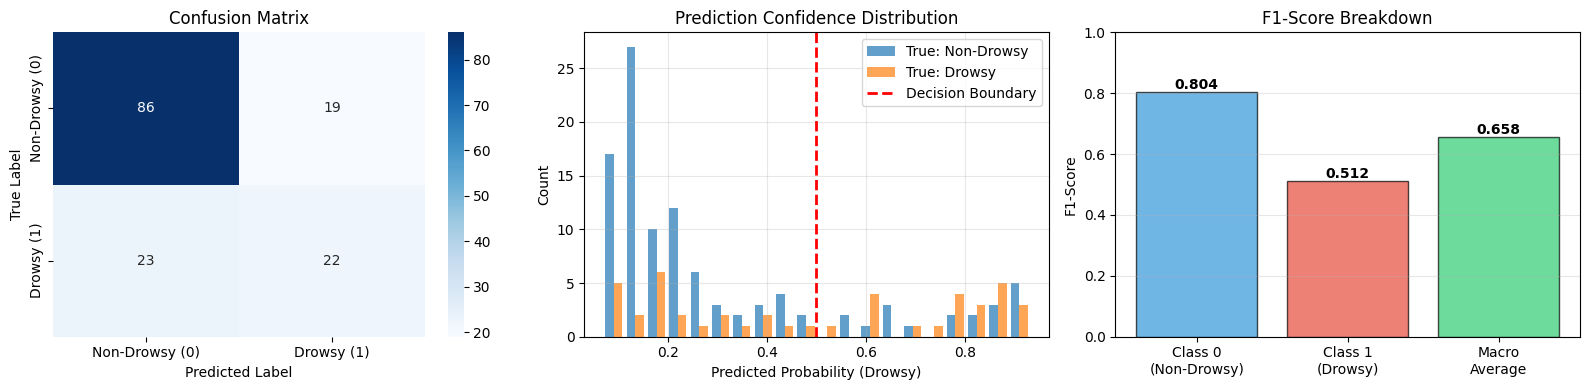

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix')

# 2. Prediction Confidence Distribution
# all_probabilities already contains probability of class 1 (drowsy)
axes[1].hist([all_probabilities[all_true_labels == 0], all_probabilities[all_true_labels == 1]], 
             bins=20, alpha=0.7, label=['True: Non-Drowsy', 'True: Drowsy'])
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='Decision Boundary')
axes[1].set_xlabel('Predicted Probability (Drowsy)')
axes[1].set_ylabel('Count')
axes[1].set_title('Prediction Confidence Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. F1 Scores Comparison
f1_scores = [f1_per_class[0], f1_per_class[1], f1_macro]
labels = ['Class 0\n(Non-Drowsy)', 'Class 1\n(Drowsy)', 'Macro\nAverage']
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = axes[2].bar(labels, f1_scores, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('F1-Score Breakdown')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Generate Test Set Predictions for Competition Submission

In [6]:
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image

# Custom Dataset for Test Set (no labels)
class TestVideoDataset(Dataset):
    def __init__(self, root, seq_len=30, transform=None):
        self.root = Path(root)
        self.seq_len = seq_len
        
        # Get all test sequence folders
        self.items = []
        for video_dir in sorted(self.root.iterdir()):
            if video_dir.is_dir() and video_dir.name.startswith('test_seq_'):
                self.items.append(video_dir)
        
        self.transform = transform or T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
    
    def __len__(self):
        return len(self.items)
    
    def _load_sequence(self, folder):
        frames = []
        files = sorted([p for p in folder.iterdir() if p.suffix.lower() in ('.jpg','.jpeg','.png')])
        
        if len(files) >= self.seq_len:
            files = files[:self.seq_len]
        
        for i in range(self.seq_len):
            if i < len(files):
                img = Image.open(files[i]).convert('RGB')
            else:
                # repeat last available
                img = Image.open(files[-1]).convert('RGB')
            img_t = self.transform(img)
            frames.append(img_t)
        
        seq = torch.stack(frames, dim=0)  # (seq_len, C, H, W)
        return seq
    
    def __getitem__(self, idx):
        folder = self.items[idx]
        seq = self._load_sequence(folder)
        folder_name = folder.name  # e.g., 'test_seq_00019'
        return seq, folder_name

print("Test dataset class defined")

Test dataset class defined


In [7]:
# Configuration for test set
TEST_DATA_ROOT = "./test_cropped"
TEST_BATCH_SIZE = 8

# Create test dataset (without labels)
test_dataset = TestVideoDataset(
    TEST_DATA_ROOT,
    seq_len=SEQ_LEN
)

test_loader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of test batches: {len(test_loader)}")

Test dataset size: 602
Number of test batches: 76


In [8]:
# Run inference on test set
test_predictions = []
test_ids = []

print("Running inference on test set...")
model.eval()

with torch.no_grad():
    for sequences, folder_names in tqdm(test_loader, desc="Test Inference"):
        # Model only receives sequences
        sequences = sequences.to(device)
        
        # Forward pass
        logits = model(sequences)  # (B, 1)
        
        # Apply sigmoid to get probability for class 1 (drowsy)
        probs_class1 = torch.sigmoid(logits).squeeze()  # (B,)
        
        # Threshold at 0.5 for binary classification
        preds = (probs_class1 > 0.5).long()  # (B,)
        
        # Store results
        test_predictions.extend(preds.cpu().numpy().tolist())
        test_ids.extend(folder_names)

print(f"\n✓ Test inference complete!")
print(f"Total test samples processed: {len(test_predictions)}")

Running inference on test set...


Test Inference:   0%|          | 0/76 [00:00<?, ?it/s]


✓ Test inference complete!
Total test samples processed: 602


In [9]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})

# Sort by id to ensure proper ordering
submission_df['seq_num'] = submission_df['id'].str.extract(r'(\d+)').astype(int)
submission_df = submission_df.sort_values('seq_num').drop('seq_num', axis=1).reset_index(drop=True)

# Save to CSV
submission_path = "submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission file saved to: {submission_path}")
print(f"\nSubmission preview:")
print(submission_df.head(10))

# Display label distribution
print(f"\n{'='*60}")
print("SUBMISSION LABEL DISTRIBUTION")
print("="*60)
label_dist = submission_df['label'].value_counts().sort_index()
print(f"Label 0 (Non-Drowsy): {label_dist.get(0, 0)} samples ({label_dist.get(0, 0)/len(submission_df)*100:.2f}%)")
print(f"Label 1 (Drowsy):     {label_dist.get(1, 0)} samples ({label_dist.get(1, 0)/len(submission_df)*100:.2f}%)")
print(f"Total:                {len(submission_df)} samples")

Submission file saved to: submission.csv

Submission preview:
               id  label
0  test_seq_00001      0
1  test_seq_00002      1
2  test_seq_00003      0
3  test_seq_00004      1
4  test_seq_00005      1
5  test_seq_00006      0
6  test_seq_00007      1
7  test_seq_00008      0
8  test_seq_00009      0
9  test_seq_00010      0

SUBMISSION LABEL DISTRIBUTION
Label 0 (Non-Drowsy): 429 samples (71.26%)
Label 1 (Drowsy):     173 samples (28.74%)
Total:                602 samples
